
## Ecommerce Customer Segmentation & Business Insight Dashboard

**End-to-End Analytics with Python, SQL (DuckDB), and Power BI**


---

### **Project Objective**

This notebook presents a comprehensive analysis of an ecommerce dataset containing \~4,000 customer transactions over a one-year period (2010-12-01 to 2011-12-09). The goal is to build an **end-to-end analytics pipeline** that:

* Cleans and enriches raw transactional data using **Python**
* Creates structured **dimensional and fact tables**
* Segments customers using an enhanced **RFMT model**
* Builds performance-ready datasets using **DuckDB SQL**
* Shares insights through an interactive **Power BI dashboard**

---

### **Business Use Case**

This project simulates a real-world business objective: understanding customer behavior and optimizing marketing efforts. The key goals are to:

* **Identify and profile high-value customers (VIPs)**
* **Monitor return and cancellation behavior**
* **Track core KPIs (sales, active users, invoices) over time**
* **Detect suspicious or potentially fraudulent activity**

---

### **RFMT Model: Recency, Frequency, Monetary, Tenure (+ Item Frequency)**

The classic **RFM** model is extended to include:

* **T = Tenure** – how long the customer has been with the business
* **Item Frequency** – total unique items purchased

This improved RFMT+ model allows us to:

* Score each customer on **Recency**, **Frequency**, **Monetary**, **Tenure**, and **Item Frequency**
* Segment customers into **5 ranked segments**
* Detect anomalies (e.g., customers with negative net spend → potential fraud)

---

### **Workflow Outline**

#### **1. Data Ingestion & Exploration**

* Load and clean ecommerce transactional data
* Generate descriptive statistics
* Explore missing data and return patterns

#### **2. Feature Engineering & Data Modeling**

* Create new fields: `TotalPrice`, `TransactionType`, `CustomerStatus`, `InvoiceHour`, etc.
* Add temporal granularity: week, weekday, hour


#### **3. RFMT Segmentation**

* Calculate RFMT and Item Frequency metrics
* Assign quantile-based scores (1–5)
* Label top customer segments and flag frauds
* Create interpretable segmentation profiles

#### **4 Dimensional Modeling (Star Schema) **:

  * `fact_transactions`
  * `dim_customer`
  * `dim_product`
  * `dim_date`

#### **5. Business Summary with DuckDB**

* Use DuckDB SQL to generate:

  * **Daily & weekly sales summaries**
  * **Customer activity & return analysis**
  * **Top product purchases by segment**
* Export curated tables for visualization

#### **6. Power BI Dashboard**

* Design interactive dashboards with:

  * **Sales trends (daily, weekly, monthly)**
  * **Top 5 countries by sales**
  * **Customer segments by behavior**
  * **Return patterns & fraud monitoring**
* Filters: date, segment, country



### **1. Data Ingestion & Exploration**

#### Descriptive Stats

In [49]:
# STEP 1: Mount Google Drive and Set File Path
# Use Google Drive as cloud storage to simulate cloud-based data ingestion

from google.colab import drive
drive.mount('/content/drive')

# Set base path and filename
base_path = "/content/drive/My Drive/Colab Notebooks/DSO 528 full/HW1"
file_name = "data.csv"
file_path = f"{base_path}/{file_name}"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
# STEP 2: Import Libraries

import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt


In [51]:
# STEP 3: Load Dataset
# -----------------------
# Read the ecommerce transactional CSV file with appropriate encoding and data types

df = pd.read_csv(file_path, encoding="ISO-8859-1", dtype={
    'CustomerID': str,   # ensure CustomerID is string
    'InvoiceID': str     # InvoiceID field may not exist; keep for schema flexibility
})


In [52]:
# STEP 4: Initial Data Overview
# --------------------------------
# Check structure, data types, and null values

df.info()

# Generate a summary of data types, null counts, and null percentages
datamunging_summary = pd.concat([
    pd.DataFrame(df.dtypes).T.rename(index={0: 'Data Types'}),
    pd.DataFrame(df.isnull().sum()).T.rename(index={0: 'Null Count'}),
    pd.DataFrame(df.isnull().mean()).T.rename(index={0: 'Null %'})
])

datamunging_summary


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
Data Types,object,object,object,int64,object,float64,object,object
Null Count,0,0,1454,0,0,0,135080,0
Null %,0.0,0.0,0.002683,0.0,0.0,0.0,0.249267,0.0


In [55]:
# STEP 5: Data Quality Commentary

"""
Observations:

• ~25% of records are missing CustomerID — this likely indicates guest checkouts or unregistered users.
• ~0.2% of Description values are null — a minor issue that does not warrant deletion or imputation.

• Numerical fields (Quantity and UnitPrice) show:
    - High standard deviations
    - Extreme max values
    - Negative values, which are likely:
        - Returns (negative quantity)
        - Data errors (e.g., negative unit price)

These anomalies will be addressed during the data wrangling and business logic stage.
"""

'\nObservations:\n\n• ~25% of records are missing CustomerID — this likely indicates guest checkouts or unregistered users.\n• ~0.2% of Description values are null — a minor issue that does not warrant deletion or imputation.\n\n• Numerical fields (Quantity and UnitPrice) show:\n    - High standard deviations\n    - Extreme max values\n    - Negative values, which are likely:\n        - Returns (negative quantity)\n        - Data errors (e.g., negative unit price)\n\nThese anomalies will be addressed during the data wrangling and business logic stage.\n'

#### Explore the Return Transaction

In [56]:
#  STEP 6: Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


/tmp/ipython-input-56-2736705224.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [57]:
# STEP 7: Identify Return Transactions
# ---------------------------------------

# Transactions with negative quantity — likely returns or cancellations
return_invoice = df[df['Quantity'] < 0]

# Total return transactions
print("Total return transactions (Quantity < 0):", return_invoice.shape[0])  # 10,624

# Transactions where InvoiceNo contains 'C' — often labeled as Credit Memos
credit_memo_count = df[df['InvoiceNo'].str.contains('C')].shape[0]
print("Total transactions with 'C' in InvoiceNo:", credit_memo_count)  # 9,288

# Proportion of return transactions in full dataset
print("Return % of total transactions:", round(return_invoice.shape[0] / df.shape[0] * 100, 2), "%")

# How many returns actually contain 'C' in InvoiceNo?
print("Proportion of returns that are credit memos:", round(credit_memo_count / return_invoice.shape[0] * 100, 2), "%")


Total return transactions (Quantity < 0): 10624
Total transactions with 'C' in InvoiceNo: 9288
Return % of total transactions: 1.96 %
Proportion of returns that are credit memos: 87.42 %


In [58]:
# STEP 8: Investigate Returns WITHOUT 'C' in InvoiceNo
# ------------------------------------------------------

# Check if they all have UnitPrice = 0
returns_no_c = return_invoice[~return_invoice['InvoiceNo'].str.contains('C')]
unique_unit_prices = returns_no_c['UnitPrice'].unique()
print("Unique UnitPrices for returns without 'C':", unique_unit_prices)

# Explore proportion of UnitPrice = 0
unitprice_zero_total = df[df['UnitPrice'] == 0].shape[0]
unitprice_zero_in_returns = return_invoice[return_invoice['UnitPrice'] == 0].shape[0]

print("Proportion of zero UnitPrice returns among all zero price:", round(unitprice_zero_in_returns / unitprice_zero_total * 100, 2), "%")
print("Proportion of zero UnitPrice in returns:", round(unitprice_zero_in_returns / return_invoice.shape[0] * 100, 2), "%")


Unique UnitPrices for returns without 'C': [0.]
Proportion of zero UnitPrice returns among all zero price: 53.12 %
Proportion of zero UnitPrice in returns: 12.58 %


In [59]:
# 🔡 STEP 9: Analyze Return Product Codes with Alpha-only StockCode
# ------------------------------------------------------------------

return_alpha_codes = return_invoice[return_invoice['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()

print("\nReturn-related non-numeric StockCodes and their descriptions:\n")
for code in return_alpha_codes:
    description = df[df['StockCode'] == code]['Description'].unique()[0]
    print(f"{code:<15} -> {description}")



Return-related non-numeric StockCodes and their descriptions:

D               -> Discount
POST            -> POSTAGE
BANK CHARGES    -> Bank Charges
S               -> SAMPLES
AMAZONFEE       -> AMAZON FEE
M               -> Manual
C2              -> CARRIAGE
DCGS0055        -> nan
DCGS0072        -> nan
DCGS0074        -> nan
DOT             -> DOTCOM POSTAGE
DCGS0057        -> nan
DCGS0073        -> ebay
DCGS0071        -> nan
DCGS0070        -> CAMOUFLAGE DOG COLLAR
DCGS0069        -> OOH LA LA DOGS COLLAR
DCGS0068        -> ebay
DCGS0067        -> ebay
DCGS0066P       -> nan
DCGS0003        -> BOXED GLASS ASHTRAY
CRUK            -> CRUK Commission


#### Business Insight: Returns, Zero-Priced Transactions & Guest Customers

##### **Returns (Quantity < 0)**

* Represent approximately **2%** of all transactions.
* **87%** of these transactions have `InvoiceNo` containing `"C"` — likely system-generated **credit memos**.
* The remaining 13% of return transactions **without `"C"`** have a **`UnitPrice` of 0**, suggesting:

  * Internal **system adjustments**
  * **Refunds** processed via zero-priced lines
  * Potentially **gifts**, test orders, or write-offs

##### **Zero-Priced Items (`UnitPrice == 0`)**

* Account for nearly **3%** of total transactions.
* Over **50% of zero-priced entries** are associated with **returns**.
* These may indicate:

  * **Loyalty program giveaways**
  * **Replacement products**
  * **Test or internal transactions**

##### **Guest Customers**

* About **25% of transactions** lack a `CustomerID`.
* These likely belong to **guest users** or **one-time buyers**.
* **Removing them could introduce bias** by excluding a major segment of the customer base.

---

#### Strategic Data Handling Decisions

1. **New Column: `TransactionType`**

   * `"Buy"`: `Quantity > 0` and `UnitPrice > 0`
   * `"Return"`: `Quantity < 0` and `UnitPrice > 0`
   * `"Gift"`: `UnitPrice == 0`

2. **Guest Customer Handling**

   * **Retain** all transactions, including those without a registered `CustomerID`
   * Assign missing `CustomerID` values a **proxy ID using the `InvoiceNo`**
   * Create a `CustomerStatus` column:

     * `"Registered"` for valid IDs
     * `"Guest"` for proxy IDs

3. **Modeling Decision**

   * These distinctions are preserved in the **Fact Table**
   * Supports full **customer lifecycle tracking** and more accurate **segmentation and fraud detection**


###  **2. Feature Engineering & Data Modeling**

- TransactionType helps segment buying vs. returning vs. gifting behavior.

- CustomerStatus allows us to compare registered vs. guest performance.

- TotalPrice is foundational for monetary value calculations.

- Time Features enable flexible reporting by month, week, weekday, or hour.

- InvoiceHour is useful for peak-hour analysis and seasonality patterns.


In [60]:
# --- 1. Transaction Classification ---
# Classify each row by transaction type based on Quantity and UnitPrice
df.loc[(df['Quantity'] < 0) & (df['UnitPrice'] != 0), 'TransactionType'] = 'Return'  # Return or cancellation
df.loc[(df['Quantity'] > 0) & (df['UnitPrice'] != 0), 'TransactionType'] = 'Buy'     # Approved purchase
df.loc[df['UnitPrice'] == 0, 'TransactionType'] = 'Gift'                             # Free or adjusted item

# --- 2. Customer Identification ---
# Identify customer registration status
df['CustomerStatus'] = df['CustomerID'].apply(lambda x: 'Guest' if pd.isna(x) else 'Registered')

# For guest customers, use InvoiceNo as a temporary unique CustomerID
df['CustomerID'] = df['CustomerID'].fillna(df['InvoiceNo'])

# --- 3. Transaction Value Calculation ---
# Compute total price for each transaction line
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# --- 4. Time-Derived Features for Reporting & Aggregation ---
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M').astype(str)       # Monthly grouping (e.g., "2011-01")
df['InvoiceYear'] = df['InvoiceDate'].dt.year                              # Year of transaction
df['InvoiceWeekday'] = df['InvoiceDate'].dt.day_name()                     # Weekday name (e.g., "Monday")
df['InvoiceWeekEndMS'] = (df['InvoiceDate'] + pd.offsets.Week(weekday=6)).dt.date  # Sunday-end week
df['InvoiceWeekEndSS'] = (df['InvoiceDate'] + pd.offsets.Week(weekday=5)).dt.date  # Saturday-end week
df['InvoiceDatetimeHour'] = df['InvoiceDate'].dt.floor('H')                # Round down to the hour
df['InvoiceHour'] = df['InvoiceDate'].dt.hour                              # Extract hour for hourly analysis

# --- 5. Data Deduplication ---
df.drop_duplicates(inplace=True)



/tmp/ipython-input-60-265343392.py:24: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['InvoiceDatetimeHour'] = df['InvoiceDate'].dt.floor('H')                # Round down to the hour


### **3. RFMT Segmentation**

In [61]:
# Filter only Buy and Return for aggregation (exclude Gift if needed)
filtered_df = df[df['TransactionType'].isin(['Buy', 'Return'])]

# Group and compute metrics
rfmt = filtered_df.groupby('CustomerID').agg(
    LastPurchase=('InvoiceDate', lambda x: x[df.loc[x.index, 'TransactionType'] == 'Buy'].max()),
    FirstPurchase=('InvoiceDate', lambda x: x[df.loc[x.index, 'TransactionType'] == 'Buy'].min()),
    Frequency=('InvoiceNo', 'nunique'),
    Frequency_Buy=('TransactionType', lambda x: (x == 'Buy').sum()),
    Frequency_Return=('TransactionType', lambda x: (x == 'Return').sum()),
    Monetary_Buy=('TotalPrice', lambda x: x[df.loc[x.index, 'TransactionType'] == 'Buy'].sum()),
    Monetary_Return=('TotalPrice', lambda x: x[df.loc[x.index, 'TransactionType'] == 'Return'].sum()),
)

# Fill NaT with min date (or leave if you want to track missingness)
reference_date = df['InvoiceDate'].max()
rfmt['LastPurchase'] = rfmt['LastPurchase'].fillna(rfmt['FirstPurchase'])
rfmt['FirstPurchase'] = rfmt['FirstPurchase'].fillna(reference_date)

# Calculate derived fields
rfmt['Recency'] = (reference_date - rfmt['LastPurchase']).dt.days.fillna(0)
rfmt['Tenure'] = (reference_date - rfmt['FirstPurchase']).dt.days.fillna(0)
rfmt['Monetary'] = rfmt['Monetary_Buy'].fillna(0) + rfmt['Monetary_Return'].fillna(0)
rfmt['FrequencyItem'] = rfmt['Frequency_Buy'].fillna(0) + rfmt['Frequency_Return'].fillna(0)


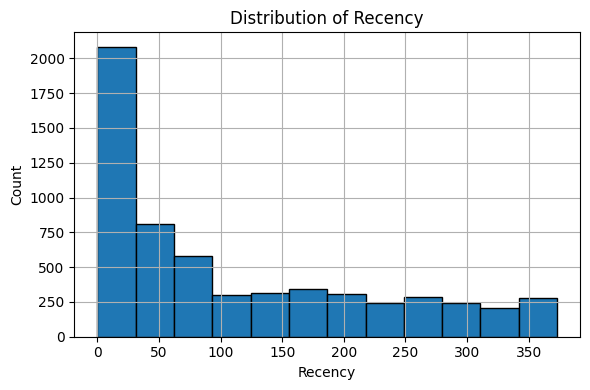

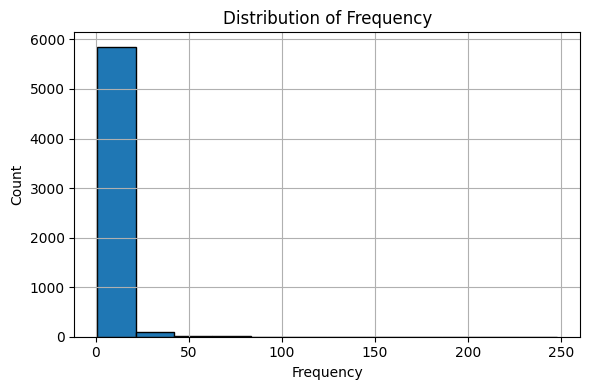

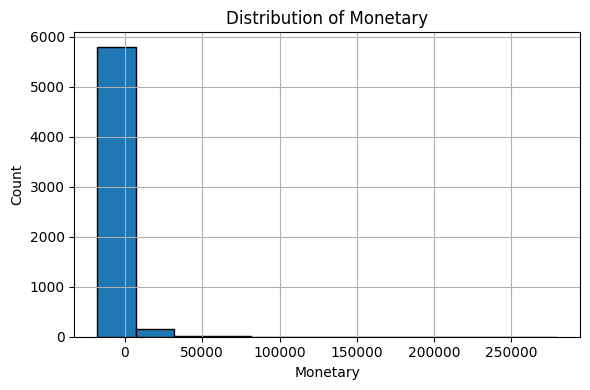

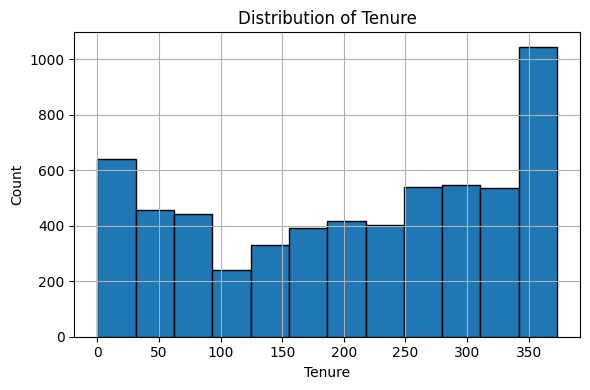

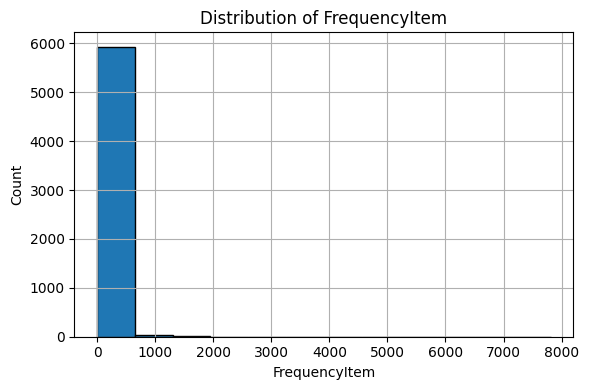

In [62]:
## Distribution of RFMT Metrics

score = ['Recency', 'Frequency', 'Monetary', 'Tenure', 'FrequencyItem']

for m in score:
    plt.figure(figsize=(6, 4))
    plt.hist(rfmt[m], bins=12, edgecolor='black')
    plt.title(f'Distribution of {m}')
    plt.xlabel(m)
    plt.ylabel('Count')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#### Insights from the Distributions
- Frequency, Monetary, and FrequencyItem are **highly right-skewed**.

- The majority of customers made only one transaction, and purchased few items with low total spend.

- A small number of customers made frequent and high-value purchases, indicating a long tail of VIPs.

- Recency and Tenure have wider distributions:

- Some customers are still active, while others have not made a purchase for several months.

- Tenure varies significantly, reflecting a mix of new vs. long-term customers.

These patterns are typical in ecommerce and support the use of quantile-based scoring in RFMT segmentation.

#### Identify and Flag Fraudulent Customers
Some customers have a negative or zero total monetary value, meaning:

They returned more than they bought.

Or never made any successful (paid) transactions.

This may indicate refund abuse, fraud, or system edge cases.

In [68]:
fraud = rfmt[rfmt['Monetary']<=0]
rfmt = rfmt[rfmt['Monetary'] > 0]

In [63]:


# Load RFMT table
rfmt = rfmt.reset_index()

# Rank each metric into 5 quantile-based buckets (1 to 5)
rfmt['RecencyScore'] = pd.qcut(rfmt['Recency'], 5, labels=[5, 4, 3, 2, 1]).astype(int)
rfmt['FrequencyScore']= pd.cut(
    rfmt['Frequency'].rank(method='first'),
    bins=5,
    labels=[1, 2, 3, 4, 5]
).astype(int)

rfmt['MonetaryScore'] = pd.qcut(rfmt['Monetary'], 5, labels=[1, 2, 3, 4, 5]).astype(int)
rfmt['TenureScore'] = pd.qcut(rfmt['Tenure'], 5, labels=[1, 2, 3, 4, 5]).astype(int)

# Optional: Weighted Final Score (e.g., double weight for F and M)
rfmt['WeightedScore'] = (
    rfmt['RecencyScore'] * 1 +
    rfmt['FrequencyScore'] * 2 +
    rfmt['MonetaryScore'] * 2 +
    rfmt['TenureScore'] * 1
)


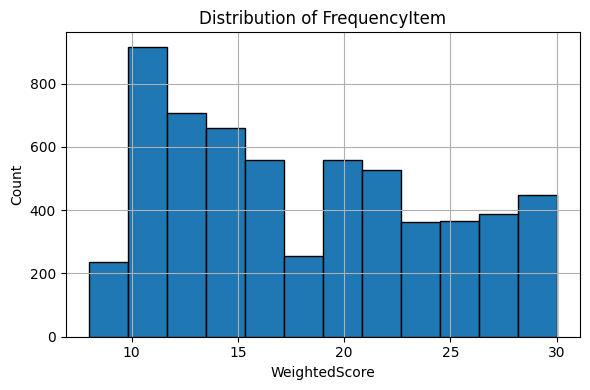

In [64]:
plt.figure(figsize=(6, 4))
plt.hist(rfmt['WeightedScore'], bins=12, edgecolor='black')
plt.title(f'Distribution of {m}')
plt.xlabel('WeightedScore')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()


#### RFMT Model Summary by Weighted Score

In [65]:


rfmt.groupby('WeightedScore').agg(

      RecencyMean =('Recency', np.mean),
      FrequencyMean =('Frequency', np.mean),
      FrequencyItemMean =('FrequencyItem', np.mean),
      MonetaryMean =('Monetary', np.mean),
      TenureMean =('Tenure', np.mean),
)

/tmp/ipython-input-65-927253964.py:3: FutureWarning: The provided callable <function mean at 0x7fded89ea3e0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  rfmt.groupby('WeightedScore').agg(


,RecencyMean,FrequencyMean,FrequencyItemMean,MonetaryMean,TenureMean
WeightedScore,,,,,
8,149.010417,1.000000,9.062500,98.835521,149.010417
9,160.942446,1.000000,9.374101,101.856259,160.942446
10,154.721133,1.000000,12.962963,113.872527,154.721133
11,181.566740,1.000000,14.544858,171.033764,181.566740
12,198.352113,1.025822,17.889671,169.036362,198.382629
13,131.219858,1.117021,20.868794,293.433691,131.776596
14,82.161446,1.154217,17.301205,-440.318458,82.872289
15,183.696721,1.409836,35.594262,507.876393,191.950820
16,167.111111,1.589744,78.440171,792.043675,194.777778


In [66]:
def segment_customer(score):
    if score <= 12:
        return 'At Risk'
    elif score <= 17:
        return 'New & Growing'
    elif score <= 21:
        return 'Active'
    elif score <= 25:
        return 'Loyal'
    else:
        return 'VIP'

rfmt['Segment'] = rfmt['WeightedScore'].apply(segment_customer)


In [69]:
fraud['is_Fraud'] =1

rfmt['is_Fraud'] = 0


rfmt_full = pd.concat([rfmt, fraud], axis=0, ignore_index=True)

### **4.Dimensional Modeling (Star Schema)**:

In [70]:
# Re-running logic now that structure is confirmed and waiting for re-upload
# We'll create the schema for fact and dimension tables using example structure

# Create fact_transactions table
fact_transactions = df[['CustomerID', 'InvoiceNo', 'InvoiceDate', 'StockCode', 'Quantity',
                        'UnitPrice', 'TotalPrice', 'TransactionType']].drop_duplicates()

# Create dim_customer table
dim_customer = df[['CustomerID', 'Country','CustomerStatus']].drop_duplicates().merge(
    rfmt_full[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'Tenure', 'WeightedScore', 'Segment','is_Fraud']],
    on='CustomerID', how='left'
).drop_duplicates()


# Create dim_product table
dim_product = df[['StockCode', 'Description']].drop_duplicates()

# Create dim_date table
dim_date = df[['InvoiceDate', 'InvoiceMonth', 'InvoiceYear', 'InvoiceWeekday',
               'InvoiceWeekEndMS', 'InvoiceWeekEndSS', 'InvoiceDatetimeHour', 'InvoiceHour']].drop_duplicates()


### **5. Business Summary with DuckDB**
Use DuckDB SQL to generate:

Daily & weekly sales summaries
Customer activity & return analysis
Top product purchases by segment
Export curated tables for visualization



In [71]:
import duckdb
# Create DuckDB in-memory connection and register the DataFrame as a table
con = duckdb.connect()
con.register("fact", fact_transactions)
con.register("cust", dim_customer)
con.register("prod", dim_product)
con.register("dt", dim_date)

In [72]:
# 1. Business Overview Summary (Daily)
daily_summary = con.execute("""
    SELECT
        dt.InvoiceDate,
        dt.InvoiceMonth,
        dt.InvoiceYear,
        dt.InvoiceWeekday,
        dt.InvoiceHour,
        dt.InvoiceWeekEndMS,
        dt.InvoiceWeekEndSS,
        c.Segment,
        c.Country,
        COUNT(DISTINCT CASE WHEN f.TransactionType = 'Buy' THEN f.InvoiceNo END) AS InvoiceCount_Buy,
        COUNT(DISTINCT CASE WHEN f.TransactionType = 'Buy' THEN f.CustomerID END) AS ActiveCustomers_Buy,
        SUM(CASE WHEN f.TransactionType = 'Buy' THEN f.Quantity ELSE 0 END) AS TotalQuantity_Buy,
        SUM(CASE WHEN f.TransactionType = 'Buy' THEN f.TotalPrice ELSE 0 END) AS TotalSales_Buy,
        SUM(CASE WHEN f.TransactionType = 'Buy' THEN f.TotalPrice ELSE 0 END) /
            NULLIF(COUNT(DISTINCT CASE WHEN f.TransactionType = 'Buy' THEN f.CustomerID END), 0)
            AS AvgSalesPerCustomer_Buy,
        COUNT(DISTINCT CASE WHEN f.TransactionType = 'Return' THEN f.CustomerID END) AS ReturnCustomers,
        SUM(CASE WHEN f.TransactionType = 'Return' THEN f.TotalPrice ELSE 0 END) AS TotalSales_Return
    FROM fact f
    JOIN cust c ON f.CustomerID = c.CustomerID
    JOIN dt ON f.InvoiceDate = dt.InvoiceDate
    GROUP BY
        dt.InvoiceDate, dt.InvoiceMonth, dt.InvoiceYear, dt.InvoiceWeekday,
        dt.InvoiceHour, dt.InvoiceWeekEndMS, dt.InvoiceWeekEndSS,
        c.Segment, c.Country
    ORDER BY dt.InvoiceDate
""").df()



In [73]:
# 2. Top Products by Segment
top_products_by_segment = con.execute("""
    SELECT
        c.Segment,
        p.Description,
        SUM(f.Quantity) AS TotalQuantity,
        SUM(f.TotalPrice) AS TotalSales
    FROM fact f
    JOIN cust c ON f.CustomerID = c.CustomerID
    JOIN prod p ON f.StockCode = p.StockCode
    WHERE f.TransactionType = 'Buy'
    GROUP BY c.Segment, p.Description
    ORDER BY c.Segment, TotalSales DESC
""").df()

In [74]:
# 3. Return Analysis
return_analysis = con.execute("""
    SELECT
        dt.InvoiceDate,
        c.Segment,
        c.Country,
        COUNT(DISTINCT f.InvoiceNo) AS ReturnInvoiceCount,
        COUNT(DISTINCT f.CustomerID) AS ReturnCustomers,
        SUM(f.Quantity) AS ReturnedQuantity,
        SUM(f.TotalPrice) AS ReturnedSales
    FROM fact f
    JOIN cust c ON f.CustomerID = c.CustomerID
    JOIN dt ON f.InvoiceDate = dt.InvoiceDate
    WHERE f.TransactionType = 'Return'
    GROUP BY dt.InvoiceDate, c.Segment, c.Country
    ORDER BY dt.InvoiceDate
""").df()

In [75]:
download_path =  "/content/drive/My Drive/Colab Notebooks/data n project/profile"

In [76]:
top_products_by_segment.to_csv(f"{download_path}/top_products_by_segment.csv", index=False)

In [ ]:
daily_summary.to_csv(f"{download_path}/daily_summary.csv", index=False)
top_products_by_segment.to_csv(f"{download_path}/top_products_by_segment.csv", index=False)
return_analysis.to_csv(f"{download_path}/return_analysis.csv", index=False)

### **6. Power BI Dashboard**
Design interactive dashboards with:

- Sales trends (daily, weekly, monthly)
- Top 5 countries by sales
- Customer segments by behavior
Filters: date, segment, country